In [4]:
import pandas as pd
import psycopg2

# --- DB Configuration (Use the same details as your import script) ---
DB_NAME = "engagement drop"
DB_USER = "postgres"
DB_PASSWORD = "7860"
DB_HOST = "localhost"
# --------------------------------------------------------------------

# Connect to the database
conn_string = f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}'"
conn = psycopg2.connect(conn_string)

# --- Define the SQL Query (Your Step 5 Result) ---
# This query calculates the average daily plays segmented by region
SQL_QUERY = """
SELECT
    event_date,
    region,
    AVG(plays) AS avg_daily_plays_region
FROM (
    SELECT
        event_date,
        user_id,
        region,
        COUNT(CASE WHEN event_type = 'video_play' THEN 1 END) AS plays
    FROM engagement_events
    WHERE event_type IN ('video_play', 'video_stop', 'video_complete')
    GROUP BY 1, 2, 3
) AS user_daily_summary
GROUP BY 1, 2
ORDER BY event_date, region;
"""

# Load the SQL query results directly into a Pandas DataFrame
try:
    df_segment_analysis = pd.read_sql_query(SQL_QUERY, conn)
    print("Successfully loaded segment-level time-series data into a DataFrame.")
    print(df_segment_analysis.head())

except Exception as e:
    print(f"Error executing query: {e}")
    
finally:
    # Always close the connection when done
    if conn:
        conn.close()

C:\Users\12vat\AppData\Local\Temp\ipykernel_10292\2619842106.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_segment_analysis = pd.read_sql_query(SQL_QUERY, conn)


Successfully loaded segment-level time-series data into a DataFrame.
   event_date    region  avg_daily_plays_region
0  2025-11-10      APAC                3.605081
1  2025-11-10   EU-West                3.665208
2  2025-11-10   IN-East                3.698113
3  2025-11-10  IN-North                3.614987
4  2025-11-10  IN-South                3.609694


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df_segment_analysis.head()

,event_date,region,avg_daily_plays_region
0,2025-11-10,APAC,3.605081
1,2025-11-10,EU-West,3.665208
2,2025-11-10,IN-East,3.698113
3,2025-11-10,IN-North,3.614987
4,2025-11-10,IN-South,3.609694


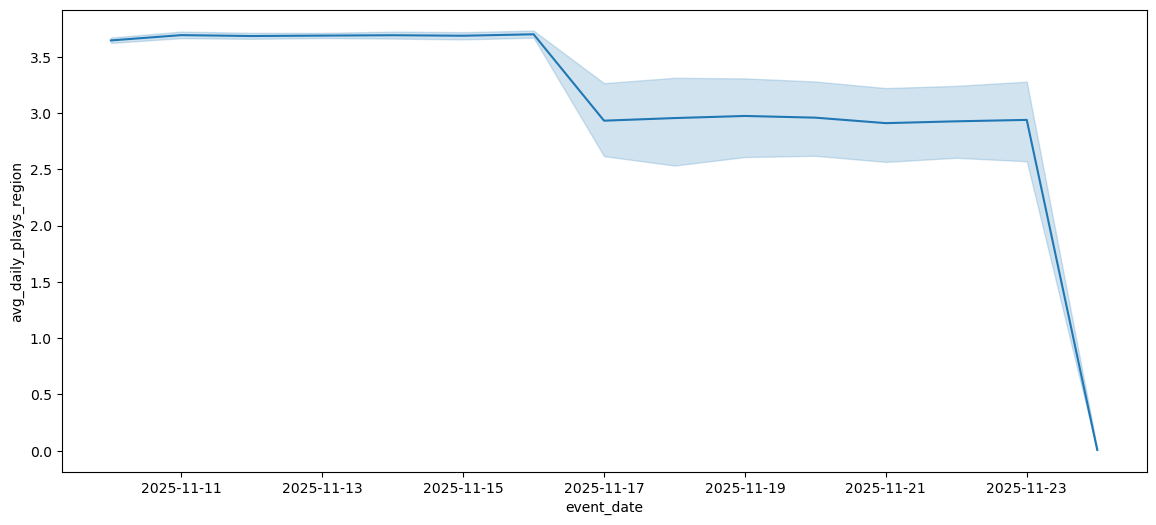

In [36]:
plt.figure(figsize=(14,6))
sns.lineplot(data = df_segment_analysis, x= 'event_date', y = 'avg_daily_plays_region')
plt.show()


✅ Visualization saved to segment_drop_analysis.png


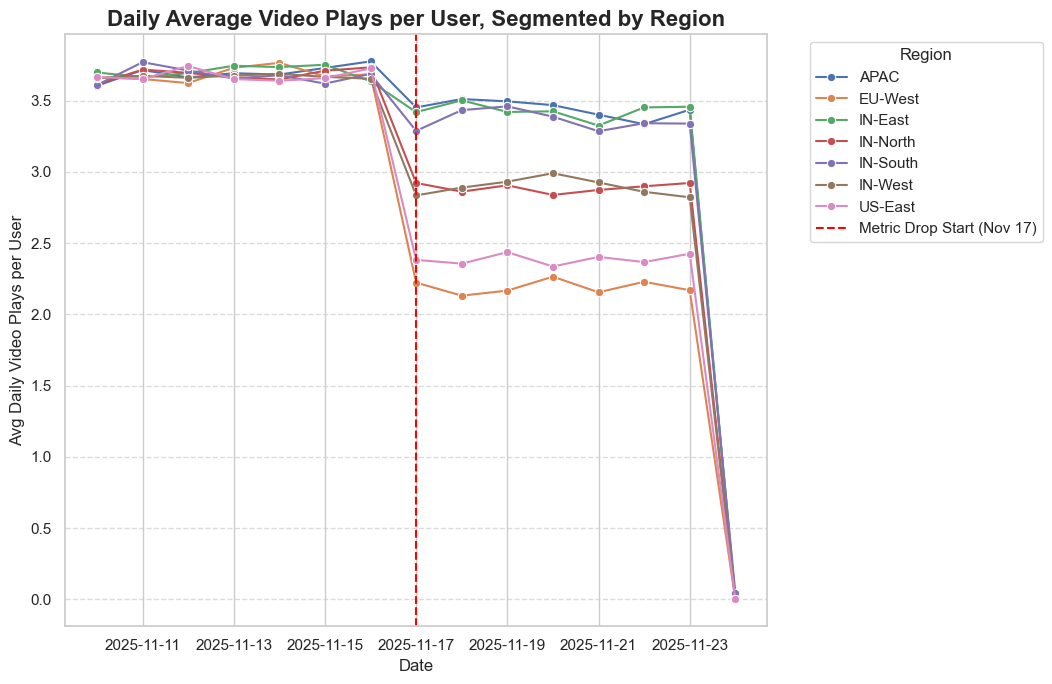

In [52]:
sns.set_theme(style="whitegrid")
    
plt.figure(figsize=(12, 7))
    
    # Create the multi-line plot
line_plot = sns.lineplot(
data=df_segment_analysis,
x='event_date',
y='avg_daily_plays_region',
hue='region', # The key segment dimension
marker='o')

DROP_DATE = pd.to_datetime('2025-11-17')
plt.axvline(x=DROP_DATE, color='red', linestyle='--', linewidth=1.5, label='Metric Drop Start (Nov 17)')
    
    # Set titles and labels
plt.title('Daily Average Video Plays per User, Segmented by Region', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Avg Daily Video Plays per User', fontsize=12)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
    
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout for the legend
    
    # 4. Save the plot
PLOT_FILE = "segment_drop_analysis.png"
plt.savefig(PLOT_FILE)
print(f"\n✅ Visualization saved to {PLOT_FILE}")

Database connection established.


C:\Users\12vat\AppData\Local\Temp\ipykernel_10292\200137557.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_bounce_analysis = pd.read_sql_query(SQL_QUERY_BOUNCE, conn)


Segmented bounce rate data loaded successfully.

✅ Visualization saved to segment_bounce_analysis.png
Database connection closed.


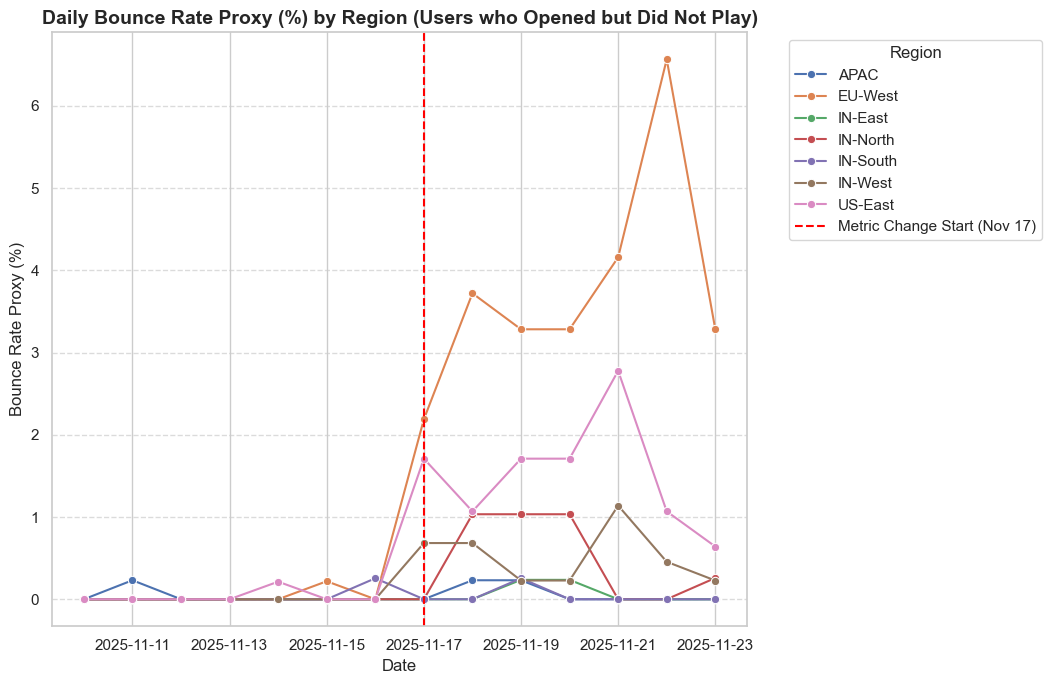

In [60]:
# --- 🎯 CONFIGURATION: UPDATE THESE ---
# NOTE: Using the variables you provided.
DB_NAME = "engagement drop" # Using the correct database name from the setup
DB_USER = "postgres"
DB_PASSWORD = "7860"
DB_HOST = "localhost"
# -----------------------------------

# 1. Define the CORRECTED SQL Query for Segmented Bounce Rate Proxy
SQL_QUERY_BOUNCE = """
WITH daily_user_activity AS (
    SELECT
        event_date,
        region,
        user_id,
        MAX(CASE WHEN event_type = 'app_open' THEN 1 ELSE 0 END) AS opened_app,
        MAX(CASE WHEN event_type = 'video_play' THEN 1 ELSE 0 END) AS played_video
    FROM engagement_events
    WHERE event_type IN ('app_open', 'video_play')
    GROUP BY 1, 2, 3
)
SELECT
    event_date,
    region,
    -- CORRECTED LINE: Use NULLIF to prevent crash when the denominator (SUM of opened_app) is 0.
    (CAST(SUM(CASE WHEN opened_app = 1 AND played_video = 0 THEN 1 ELSE 0 END) AS NUMERIC) * 100.0) /
    NULLIF(SUM(CASE WHEN opened_app = 1 THEN 1 ELSE 0 END), 0) AS daily_bounce_rate_proxy
FROM daily_user_activity
GROUP BY 1, 2
ORDER BY event_date, region;
"""

# 2. Connect to the database and execute the query
conn = None
try:
    # Use the quoted connection string format
    conn_string = f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}'"
    conn = psycopg2.connect(conn_string)
    print("Database connection established.")

    # Load SQL query results directly into a Pandas DataFrame
    df_bounce_analysis = pd.read_sql_query(SQL_QUERY_BOUNCE, conn)
    print("Segmented bounce rate data loaded successfully.")
    
    # 3. Data Cleaning and Visualization Preparation
    # Ensure event_date is a datetime type for proper plotting
    df_bounce_analysis['event_date'] = pd.to_datetime(df_bounce_analysis['event_date'])
    
    # 4. Visualization using Seaborn
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 7))
    
    # Create the multi-line plot for Bounce Rate
    line_plot = sns.lineplot(
        data=df_bounce_analysis,
        x='event_date',
        y='daily_bounce_rate_proxy',
        hue='region', # The key segment dimension
        marker='o'
    )
    
    # Annotate the drop-off date (Day 8: Nov 17, 2025)
    DROP_DATE = pd.to_datetime('2025-11-17')
    plt.axvline(x=DROP_DATE, color='red', linestyle='--', linewidth=1.5, label='Metric Change Start (Nov 17)')
    
    # Set titles and labels
    plt.title('Daily Bounce Rate Proxy (%) by Region (Users who Opened but Did Not Play)', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Bounce Rate Proxy (%)', fontsize=12)
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    
    # 5. Save the plot
    PLOT_FILE = "segment_bounce_analysis.png"
    plt.savefig(PLOT_FILE)
    print(f"\n✅ Visualization saved to {PLOT_FILE}")

except Exception as e:
    print(f"\n❌ An error occurred during the process: {e}")
    
finally:
    if conn:
        conn.close()
        print("Database connection closed.")